In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
from scipy.integrate import simps
import matplotlib.pyplot as plt
import imageio
import multiprocessing
from scipy import integrate
from helpers import Fy, find_closest_element, get_densities, get_cdf

In [2]:
# read in val data
B_zeta = np.load('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/B_zeta_val.npy')
true_y = np.load('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')

density_path = '../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [3]:
no_points = 10000
grid = np.linspace(min(density['axes']), max(density['axes']), no_points)
density_y = density['axes']
density_pdf = density['pdf']
# compute these beforehand to save computation time
p_y_y0 = [density_pdf[find_closest_element(y_i,density_y)] for y_i in grid]
part_1 = np.array([norm.ppf(Fy(y_i, density)) for y_i in grid])
phi_1_z = np.array([norm(0, 1).pdf(y_i) for y_i in part_1 ])

# VA + Ridge + Precise

In [4]:
va_ridge_dir = '../../../data/commaai/va/filtered_gaussian_resampled/Ridge/'
mu_t_va = np.genfromtxt(va_ridge_dir + 'mu_t_va.csv', delimiter = ',')
beta_va = np.mean(mu_t_va[int(0.9*50000):50000,0:10], axis = 0)
tau_sq_va = np.exp(np.mean(mu_t_va[int(0.9*50000):50000,10], axis = 0))
p = len(beta_va)

In [5]:
densities_va = get_densities(B_zeta, grid, p_y_y0, part_1, phi_1_z, beta_va, tau_sq_va, p,  'va_ridge', None)

100%|██████████| 10472/10472 [01:15<00:00, 139.45it/s]


In [8]:
av_density_va = np.mean(np.array(densities_va), axis = 0)

In [ ]:
# VA + Ridge + Imprecise

In [9]:
va_ridge_dir = '../../../data/commaai/va/unfiltered_gaussian_resampled/Ridge/'
mu_t_va_impr = np.genfromtxt(va_ridge_dir + 'mu_t_va.csv', delimiter = ',')
beta_va_impr = mu_t_va_impr[0:10]
tau_sq_va_impr = np.exp(mu_t_va_impr[10])
p = 10

In [11]:
densities_va_impr = get_densities(B_zeta, grid, p_y_y0, part_1, phi_1_z, beta_va_impr, tau_sq_va_impr, p, 'va_ridge', None)

100%|██████████| 10472/10472 [01:16<00:00, 137.15it/s]


In [20]:
av_density_ridge_impr = np.mean(np.array(densities_va_impr), axis = 0)

In [ ]:
# VA + Horseshoe + Precise

In [14]:
va_ridge_dir = '../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/'
mu_t_va_horse_pr =  np.mean(np.load(va_ridge_dir + 'mu_ts_delete.npy')[20000:,:,:], axis = 0)
beta_va_horse_pr = mu_t_va_horse_pr[0:10]
tau_sq_va_horse_pr = np.exp(mu_t_va_horse_pr[10])
p = 10

In [16]:
densities_va_horse_pr = get_densities(B_zeta, grid, p_y_y0, part_1, phi_1_z, beta_va_horse_pr, tau_sq_va_horse_pr, p, 'va_ridge', None)

100%|██████████| 10472/10472 [01:15<00:00, 138.15it/s]


In [21]:
av_density_va_horse_pr = np.mean(np.array(densities_va_horse_pr), axis = 0)

In [29]:
df = pd.DataFrame({'grid': grid, 
              'va_ridge_pr': av_density_va,
              'va_ridge_impr': av_density_ridge_impr,
              'va_horse_impr': av_density_va_horse_pr})

In [33]:
df.to_csv('marginal_calibration.csv')
np.savetxt("true_y.csv", true_y, delimiter=",")

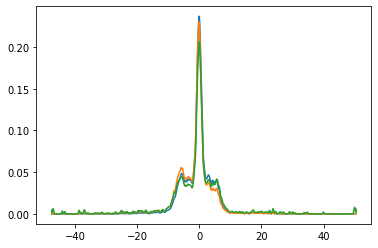

In [24]:
plt.plot(grid, av_density_va)
plt.plot(grid, av_density_ridge_impr)
plt.plot(grid, av_density_va_horse_pr)